# Part 1 - Data Analysing
## Chapter 3 - Labeling

In [173]:
import gc
import pandas as pd
from matplotlib import pyplot as plt
from utils.plotting import plot


from utils.general import load_df, reduce_memory_usage, get_t_events, get_t_events_dynamic_h, returns
from utils.bars_generator import create_dollar_bars


### 3.1 Dollar bars

In [174]:
# dates = ['2024-04', '2024-05']
dates = ['2024-05']
btc_transactions = reduce_memory_usage(
    pd.concat([
        load_df(f"data/BTCUSDT-trades-{date}.csv")
        for date in dates
    ])
)
btc_dollar = create_dollar_bars(btc_transactions, 1e8)

Memory usage of dataframe is 2326.83 MB
Memory usage after optimization is: 1939.02 MB
Decreased by 16.7%
Memory usage of dataframe is 1939.02 MB
Memory usage after optimization is: 1939.02 MB
Decreased by 0.0%
Memory usage of dataframe is 0.19 MB
Memory usage after optimization is: 0.19 MB
Decreased by 0.0%


In [175]:
def get_daily_vol(bars: pd.DataFrame, span0: int = 100):
    # daily vol, reindexed to close
    ms_a_day = 24 * 60 * 60 * 1000

    df0 = bars.index.searchsorted(bars.index - ms_a_day)
    df0 = df0[df0 > 0]
    df0 = pd.Series(bars.index[df0 - 1], index=bars.index[bars.shape[0] - df0.shape[0]:])
    df0 = bars.close.loc[df0.index] / bars.close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=span0).std()
    return df0.rename('daily_vol').dropna()


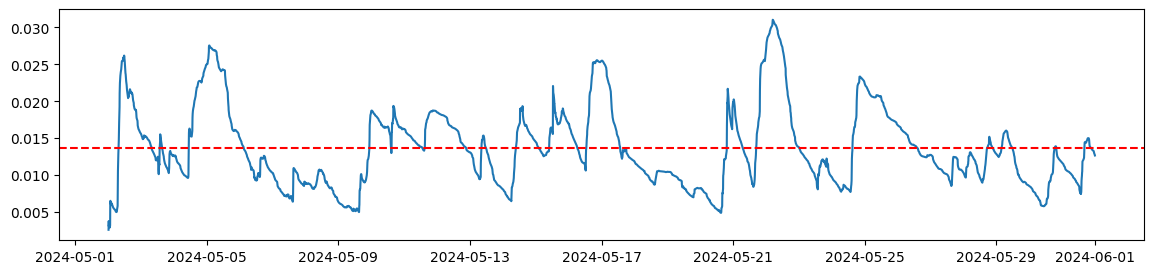

In [176]:
daily_vol = get_daily_vol(btc_dollar)
f, ax = plt.subplots(figsize=(14, 3))
ax.plot(pd.to_datetime(daily_vol.index, unit='ms'), daily_vol)
ax.axhline(daily_vol.mean(), ls='--', color='r')

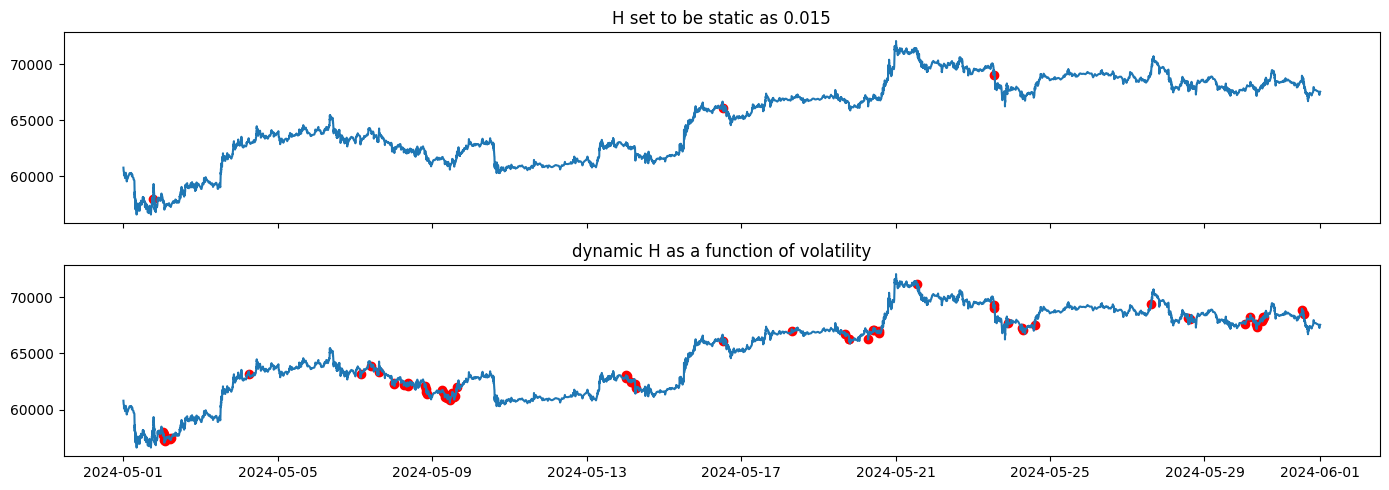

In [177]:
btc_dollar_bar_returns = returns(btc_dollar['close'])
t_events_static_h = get_t_events(
    btc_dollar.index[1:].values,
    btc_dollar_bar_returns.values,
    0.015
)

t0 = get_t_events_dynamic_h(
    btc_dollar.index[1:].values,
    btc_dollar_bar_returns.values,
    daily_vol.index.values,
    daily_vol.values,
    0.05
)
f, ax = plt.subplots(2, 1, figsize=(14, 5), sharex=True)
ax[0].set_title('H set to be static as 0.015')
ax[0].plot(pd.to_datetime(btc_dollar.index, unit='ms'), btc_dollar['close'])
ax[0].scatter(pd.to_datetime(t_events_static_h, unit='ms'), btc_dollar[btc_dollar.index.isin(t_events_static_h)]['close'], c='r')

ax[1].set_title('dynamic H as a function of volatility')
ax[1].plot(pd.to_datetime(btc_dollar.index, unit='ms'), btc_dollar['close'])
ax[1].scatter(pd.to_datetime(t0, unit='ms'), btc_dollar[btc_dollar.index.isin(t0)]['close'], c='r')

plt.tight_layout()

#### 3.1 (b) Use Snippet 3.4 on a pandas series t1, where numDays=1.

In [178]:
def get_vertical_next_day(bars: pd.DataFrame, t0: pd.Series, ms: int):
    t1 = btc_dollar.index.searchsorted(t0 + ms)
    t1 = t1[t1 < len(bars)]
    # timestamp of event -> timestamp of closed bar that as a vertical barrier
    return pd.Series(bars.index[t1].values, index=t0[:t1.shape[0]])

ms_a_day = 24 * 60 * 60 * 1000
num_days = 1
t1 = get_vertical_next_day(btc_dollar, t0, num_days * ms_a_day)


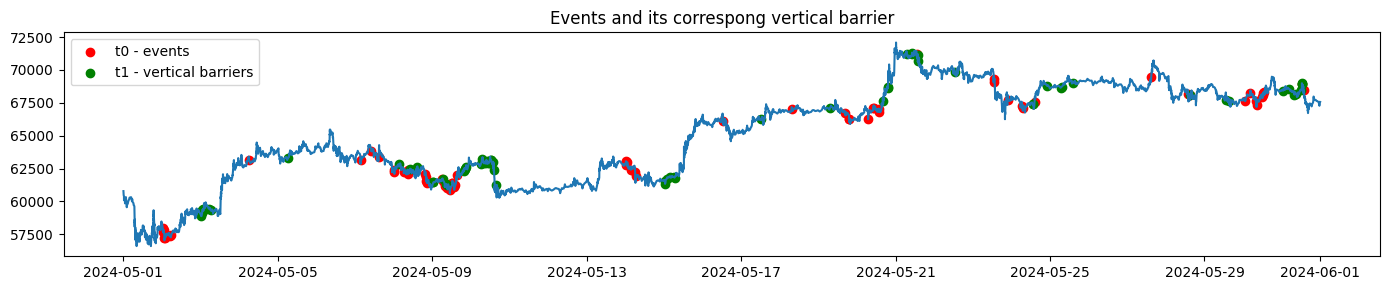

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.set_title('Events and its correspong vertical barrier')
ax.plot(pd.to_datetime(btc_dollar.index, unit='ms'), btc_dollar['close'])
ax.scatter(pd.to_datetime(t0, unit='ms'), btc_dollar.loc[t0, 'close'], c='r', label='t0 - events')
ax.scatter(pd.to_datetime(t1, unit='ms'), btc_dollar.loc[t1, 'close'], c='g', label='t1 - vertical barriers')

ax.legend()
plt.tight_layout()

### 3.1 (c) Apply the triple-barrier method

In [180]:
import numpy as np


def apply_tp_sl(close: pd.Series, events, target, tp_scale, sl_scale, molecule):
    """
    Snippet 3.2
    """
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if tp_scale > 0:
        tp = tp_scale * target
    else:
        tp = pd.Series(index=events.index)  # NaNs
    if sl_scale > 0:
        sl = -sl_scale * target
    else:
        sl = pd.Series(index=events.index)  # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close.loc[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss.
        out.loc[loc, 'tp'] = df0[df0 > tp[loc]].index.min()  # earliest profit taking.
    return out


# including metalabeleing possibility
def get_events_tripple_barrier(
        close: pd.Series,
        t0: np.ndarray,
        tp_scale: float,
        sl_scale: float,
        target: pd.Series,
        min_return: float,
        t1: pd.Series | bool = False,
        side: pd.Series = None,
) -> pd.DataFrame:
    '''
    Snippet 3.3
    Getting times of the first barrier touch
    
        Parameters:
            close (pd.Series): close prices of bars
            t0 (np.ndarray): np.ndarray of timestamps that seed every barrier (they can be generated
                                  by CUSUM filter for example)
            tp_scale (float): non-negative float that sets the width of the two barriers (if 0 then no barrier)
            sl_scale (float): non-negative float that sets the width of the two barriers (if 0 then no barrier)
            target (pd.Series): s series of targets expressed in terms of absolute returns
            min_return (float): minimum target return required for running a triple barrier search
            numThreads (int): number of threads to use concurrently
            t1 (pd.Series): series with the timestamps of the vertical barriers (pass False
                            to disable vertical barriers)
            side (pd.Series) (optional): metalabels containing sides of bets
        
        Returns:
            events (pd.DataFrame): dataframe with columns:
                - t1: timestamp of the first barrier touch
                - target: target that was used to generate the horizontal barriers
                - side (optional): side of bets
    '''
    target = target.reindex(t0, method='ffill')
    if min_return > 0:
        target = target[target > min_return]
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=t0)
    if side is None:
        side_ = pd.Series(np.array([1.] * len(target.index)), index=target.index)
    else:
        side_ = side.loc[target.index.intersection(side.index)]
    events = pd.concat({'t1': t1, 'side': side_}, axis=1).dropna()
    df0 = apply_tp_sl(close, events, target, tp_scale, sl_scale, events.index)
    events['t1'] = df0.dropna(how='all').min(axis=1)
    events.rename(columns={'t1': 'touch'}, inplace=True)
    if side is None:
        events = events.drop('side', axis=1)
    return events


In [181]:
events = get_events_tripple_barrier(close=btc_dollar['close'], t0=t0, tp_scale=1, sl_scale=1,
                                    target=daily_vol, min_return=0.0, t1=t1)
events

,touch
1714609990028,1.714610e+12
1714610710719,1.714614e+12
1714612143147,1.714613e+12
1714612966069,1.714614e+12
1714613687032,1.714618e+12
...,...
1717057625813,1.717061e+12
1717069573928,1.717075e+12
1717072233002,1.717078e+12
1717072392004,1.717077e+12


KeyError: 't1'

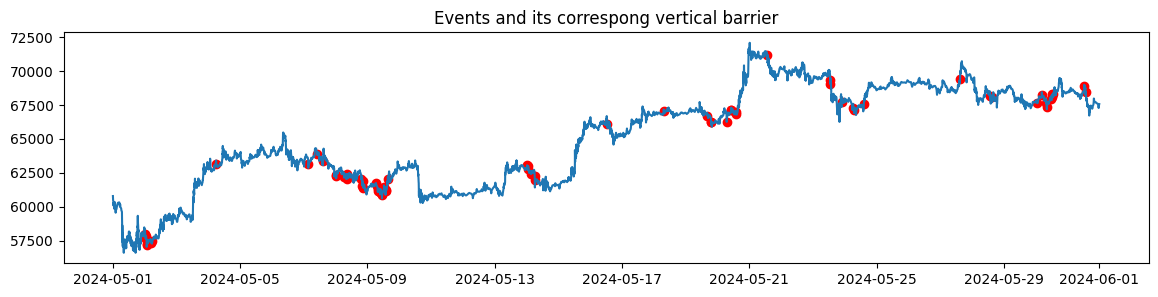

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.set_title('Events and its correspong vertical barrier')
ax.plot(pd.to_datetime(btc_dollar.index, unit='ms'), btc_dollar['close'])
ax.scatter(pd.to_datetime(t0, unit='ms'), btc_dollar.loc[t0, 'close'], c='r', label='t0 - events')
ax.scatter(pd.to_datetime(events['t1'], unit='ms'), btc_dollar.loc[events['t1'], 'close'], c='g', label='t1 - firest barrier touch')

ax.legend()
plt.tight_layout()

#### 3.1 (d) apply getBins

In [ ]:
def get_bins(events: pd.DataFrame, close: pd.Series, t1: pd.Series | None = None):
    events_ = events.dropna(subset=['touch'])
    px = events_.index.union(events_['touch'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['touch'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side']  # meta-labeling
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if t1 is not None:
        out[events_['touch'].isin(t1)] = 0
    return out

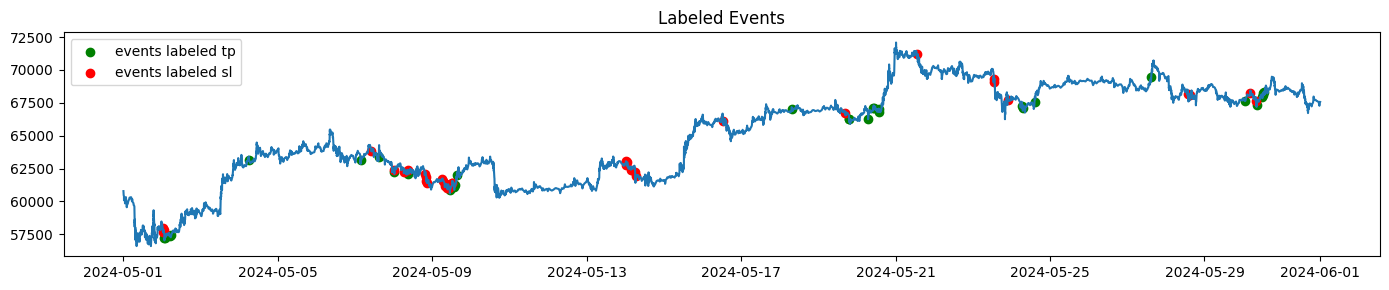

In [183]:
labeled_events = get_bins(events, btc_dollar.close)
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.set_title('Labeled Events')
ax.plot(pd.to_datetime(btc_dollar.index, unit='ms'), btc_dollar['close'])
label_tp = labeled_events[labeled_events['bin'] == 1]
label_sl = labeled_events[labeled_events['bin'] == -1]
ax.scatter(pd.to_datetime(label_tp.index, unit='ms'),
           btc_dollar.loc[label_tp.index, 'close'], c='g', label='events labeled tp')
ax.scatter(pd.to_datetime(label_sl.index, unit='ms'),
           btc_dollar.loc[label_sl.index, 'close'], c='r', label='events labeled sl')

ax.legend()
plt.tight_layout()

### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [184]:
def drop_rare_labels(events, min_percentage=.05):
    while True:
        df0 = events['bin'].value_counts(normalize=True)
        if df0.min() > min_percentage or df0.shape[0] < 3:
            break
        print('dropped label', df0.argmin(), df0.min())
        events = events[events['bin'] != df0.argmin()]

    return events

In [185]:
print(f'Total number of labels: {len(labeled_events)}')
cleaned_labels = drop_rare_labels(labeled_events)
print(f'Number of rare labels: {len(labeled_events) - len(cleaned_labels)}')

Total number of labels: 70
Number of rare labels: 0


### 3.3 Adjust the getBins function to return a 0 whenever the vertical barrier is the one touched first.

In [186]:
get_bins(events, btc_dollar.close, t1)

,ret,bin
1714609990028,-0.004266,-1.0
1714610710719,-0.008041,-1.0
1714612143147,-0.003309,-1.0
1714612966069,-0.007138,-1.0
1714613687032,0.005225,1.0
...,...,...
1717057625813,0.006147,1.0
1717069573928,0.006893,1.0
1717072233002,0.006415,1.0
1717072392004,0.006308,1.0


### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic
(e.g., crossing moving averages). For each observation, the model suggests a side,
but not a size of the bet.

In [187]:
# implement gold death cross strategy
ma20 = btc_dollar.close.rolling(window=20).mean()
ma50 = btc_dollar.close.rolling(window=50).mean()

gold_cross = (ma20 > ma50) & (ma20.shift(1) <= ma50.shift(1))
death_cross = (ma20 < ma50) & (ma20.shift(1) >= ma50.shift(1))

side = pd.Series(0, index=btc_dollar.index)
side[gold_cross] = 1
side[death_cross] = -1
side = side[gold_cross | death_cross]
t0 = side.index


#### 3.4 (a) Derive meta-labels for ptSl=[1,2] and t1 where numDays=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [188]:
t1 = get_vertical_next_day(btc_dollar, t0, num_days * ms_a_day)

events = get_events_tripple_barrier(close=btc_dollar['close'], t0=t0, tp_scale=1, sl_scale=2,
                                    target=daily_vol, min_return=0.0, t1=t1, side=side)
labeled_events = get_bins(events, btc_dollar.close)
labeled_events

,ret,bin
time,,
1714557782655,0.011885,1.0
1714572685102,-0.019520,0.0
1714586401502,0.035023,1.0
1714592044513,-0.027018,0.0
1714603787186,0.020635,1.0
...,...,...
1716970193325,0.004695,1.0
1717033833695,0.008883,1.0
1717056842967,-0.013152,0.0


#### 3.4 (b) Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underlying model (the crossing moving average) has decided the side, {−1,1}.

              precision    recall  f1-score   support

         0.0       0.41      0.46      0.43        24
         1.0       0.50      0.45      0.47        29

    accuracy                           0.45        53
   macro avg       0.45      0.45      0.45        53
weighted avg       0.46      0.45      0.45        53


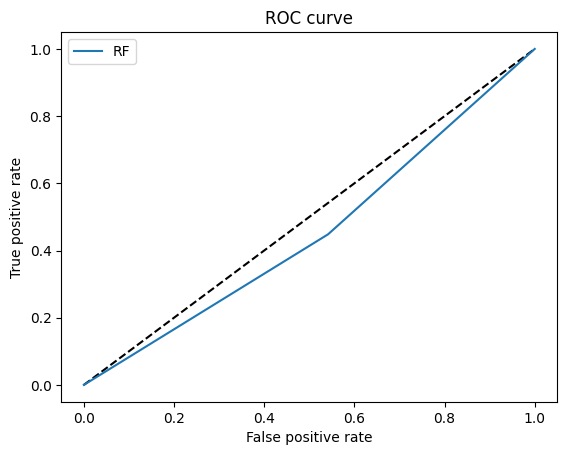

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report

X = side[labeled_events.index].values.reshape(-1,1)
y = labeled_events.bin.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    shuffle=False)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=2, n_estimators=n_estimator,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### 3.5 Develop a mean-reverting strategy based on Bollinger bands. For each observation, the model suggests a side, but not a size of the bet

In [191]:
def get_bollinger_bands(
        dollar_bars: pd.DataFrame,
        window: int,
        alpha: float,
) -> tuple[pd.Series, pd.Series, pd.Series]:
    ma = (dollar_bars.close.rolling(window, min_periods=1).mean())
    sigma = dollar_bars.close.rolling(window, min_periods=1).std()[1:]
    b_upper, b_lower = (ma + alpha * sigma), (ma - alpha * sigma)
    return ma, b_upper, b_lower


ma, upper_band, lower_band = get_bollinger_bands(btc_dollar, window=30, alpha=1)

over_buy_indices = (btc_dollar['open'].values < upper_band) & (btc_dollar['close'].values > upper_band)
over_sell_indices = (btc_dollar['open'].values > lower_band) & (btc_dollar['close'].values < lower_band)
over_buy = btc_dollar[over_buy_indices]
over_sell = btc_dollar[over_sell_indices]

over_buy_markers = [
    {"time": timestamp, "position": "below", "shape": "circle", "color": "red", "text": ""}
    for timestamp in list(pd.to_datetime(over_buy.index, unit='ms'))
]

over_sell_markers = [
    {"time": timestamp, "position": "above", "shape": "circle", "color": "green", "text": ""}
    for timestamp in list(pd.to_datetime(over_sell.index, unit='ms'))
]

lines = pd.DataFrame()
lines['Lower BB'] = lower_band 
lines['Upper BB'] = upper_band 
chart = plot(btc_dollar, lines, markers=over_buy_markers + over_sell_markers)
chart.load()

#### 3.5 (a) Derive meta-labels for ptSl=[0,2] and t1 where numDays=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.

In [192]:
t0 = btc_dollar[over_sell_indices | over_buy_indices].index
t1 = get_vertical_next_day(btc_dollar, t0, num_days * ms_a_day)

events = get_events_tripple_barrier(close=btc_dollar['close'], t0=t0, tp_scale=1, sl_scale=2,
                                    target=daily_vol, min_return=0.0, t1=t1, side=side)
labeled_events = get_bins(events, btc_dollar.close)
labeled_events

,ret,bin
time,,
1714753588380,0.013556,1.0
1714898692878,0.026337,1.0
1715042338782,0.010207,1.0
1715069006463,0.008330,1.0
1715084926275,0.006960,1.0
1715361340347,0.007988,1.0
1715521903329,0.017042,1.0
1716286459558,-0.024307,0.0
1716299438872,0.009473,1.0


### 3.5 (b) Train a random forest to decide whether to trade or not. Use as features: volatility, serial correlation, and the crossing moving averages from exercise 3.4.

In [206]:
X = pd.DataFrame(
    {
        'vol': get_daily_vol(btc_dollar),
        'autocorr': btc_dollar_bar_returns
            .rolling(20, min_periods=1)
            .corr(btc_dollar_bar_returns.shift(1))
            .dropna(),
        'side': events['side']}
).dropna()
y = labeled_events['bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


/Users/yakirhadad/PycharmProjects/Advances-In-Financial-Machine-Learning/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yakirhadad/PycharmProjects/Advances-In-Financial-Machine-Learning/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/yakirhadad/PycharmProjects/Advances-In-Financial-Machine-Learning/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

#### 3.5 (c) What is the accuracy of predictions from the primary model (i.e., if the secondary model does not filter the bets)? What are the precision, recall, and F1-scores?

#### 3.5 (d) What is the accuracy of predictions from the secondary model? What are the precision, recall, and F1-scores?